# Evaluation of experiments
fistly define the UUID of the experiment to use

In [1]:
experimentId="ca1a343f-daa3-4879-9974-993ffe1b8f8b"

-------------------------------------------------------

In [2]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time


#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [3]:
samplerate=200  #Should rethink this

In [4]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [5]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,kcomplex,E1,0001,0001,830.596676,0.699174,200,831.295850,166119,166259
1,kcomplex,E1,0001,0001,840.981316,0.492156,200,841.473472,168196,168295
2,kcomplex,E1,0001,0001,970.596678,0.578088,200,971.174766,194119,194235
3,kcomplex,E1,0001,0001,1049.772807,0.695268,200,1050.468075,209955,210094
4,kcomplex,E1,0001,0001,1077.231575,0.648396,200,1077.879971,215446,215576


In [6]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [7]:
def loadModel(modelId,experimentId,datapath):
    model=xgb.XGBClassifier()
    model.load_model(datapath+"/experiments/"+experimentId+"/"+modelId+".json")
    return model

In [8]:
def loadExperiment(experimentId,datapath):
    experimentModels=loadPickle(datapath+"/experiments/"+experimentId+"/experimentModels.pkl")
    featureSelection=loadPickle(datapath+"/experiments/"+experimentId+"/featureSelection.pkl")
    return experimentModels, featureSelection

In [9]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [10]:
experimentModels

,train,val,test,modelId,treeLimit,valF1
0,"[0002, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0014]",[0001],a0c50dbf-de0d-4807-89c8-e9fff0e96e60,17,0.621141
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0012, 0010]",[0002],50450b1f-2acb-47b6-bbde-85b5b64cf674,11,0.558384


In [11]:
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## Annotation criterium

In [12]:
usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]

## Define hyperparameters

In [17]:
hyperClose=0.25
hyperDuration=0.3
hyperConfidence=0.25

## Evaluate each row for each hyperparameter selection

In [18]:
#Set by_event IoU threshold
masterIoU=0.3

#Be conservative, keep the minimum tree limit
masterTreeLimit=np.min(experimentModels.treeLimit)
masterTreeLimit


11

In [28]:
modelMetrics=pd.DataFrame()

for ind_CV, row in experimentModels.iterrows():
    #load testing
    testFeatures=loadFeatureMatrix(row.test,featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector(row.test,usedAnnotations,signalsMetadata,samplerate)
    #predict labels
    model=loadModel(row.modelId,experimentId,datapath)
    predictedLabels=model.predict(testFeatures,ntree_limit=masterTreeLimit)
    #process labels
    processedLabels=labelingProcess(predictedLabels,hyperClose,hyperDuration,samplerate)
    #get confidence score and filter
    predictedAnnotations=labelVectorToAnnotations(predictedLabels,samplerate)
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations['confidence']=processedAnnotations.apply(
        lambda row: getConfidence(row,predictedAnnotations)
        ,axis=1)
    finalAnnotations=processedAnnotations[processedAnnotations.confidence>hyperConfidence].copy().reset_index(drop=True)
    #by event calculations
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    tp,fp,fn = byEventEvaluation(gtAnnotations,finalAnnotations,thres_IoU=masterIoU)
    #consistency check
    check=tp*2+fp+fn==len(gtAnnotations)+len(finalAnnotations)
    #calculate metrics
    finalLabels=excerptAnnotationsToLabels(finalAnnotations,len(testLabels))
    vector_F1_raw=F1(testLabels,predictedLabels)
    vector_F1=F1(testLabels,finalLabels)
    event_F1=2*tp/(2*tp+fp+fn)
    event_Precision=tp/(tp+fp)
    event_Recall=tp/(tp+fn)
    event_TS=tp/(tp+fn+fp)
    
    #append to the dataframe
    newRow=pd.Series({
        "ind_model":ind_CV,
        "thres_IoU":masterIoU,
        "treeLimit":masterTreeLimit,
        "check":check,
        "final_count":len(finalAnnotations),
        "gt_count":len(gtAnnotations),
        "tp":tp,
        "fp":fp,
        "fn":fn,
        "vector_F1_raw":vector_F1_raw,
        "vector_F1":vector_F1,
        "event_F1":event_F1,
        "event_Precision":event_Precision,
        "event_Recall":event_Recall,
        "event_TS":event_TS})
    
    modelMetrics=pd.concat([modelMetrics,newRow.to_frame().T],ignore_index=True)

    break


c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [29]:
modelMetrics

,ind_model,thres_IoU,treeLimit,check,final_count,gt_count,tp,fp,fn,vector_F1_raw,vector_F1,event_F1,event_Precision,event_Recall,event_TS
0,0,0.3,11,True,298,1044,278,20,766,0.283967,0.309672,0.414307,0.932886,0.266284,0.261278


In [125]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.9, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Calculate areas under curve
we don't use ROC because the problem is heavily inbalanced

average precision, AP, is a better choice here

In [43]:
aux=model.predict_proba(testFeatures,ntree_limit=masterTreeLimit)[:,1]

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


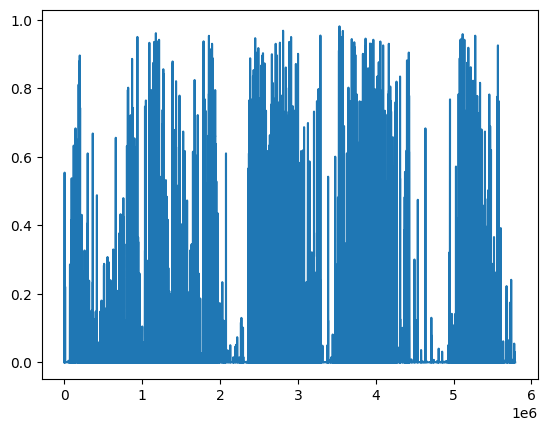

In [45]:
plt.plot(aux)

In [54]:
thresholds=np.linspace(0,1,num=100,endpoint=True)

In [65]:
precisions=[]
recalls=[]
fprs=[]
f1s=[]

for thres in thresholds:
    predictedLabels=aux>=thres
    #process labels
    processedLabels=labelingProcess(predictedLabels,hyperClose,hyperDuration,samplerate)
    finalLabels=processedLabels #<- skip the commented section
    """ #get confidence score and filter
    predictedAnnotations=labelVectorToAnnotations(predictedLabels,samplerate)
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations['confidence']=processedAnnotations.apply(
        lambda row: getConfidence(row,predictedAnnotations)
        ,axis=1)
    finalAnnotations=processedAnnotations[processedAnnotations.confidence>hyperConfidence].copy().reset_index(drop=True)
    finalLabels=excerptAnnotationsToLabels(finalAnnotations,len(testLabels)) """
    tp=np.sum(finalLabels*testLabels)
    fp=np.sum(finalLabels*(1-testLabels))
    tn=np.sum((1-finalLabels)*(1-testLabels))
    fn=np.sum((1-finalLabels)*testLabels)

    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))
    fprs.append(fp/(fp+tn))
    f1s.append(2*tp/(2*tp+fp+fn))
    

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_7820\1669684469.py:24: RuntimeWarning: invalid value encountered in double_scalars
  precisions.append(tp/(tp+fp))


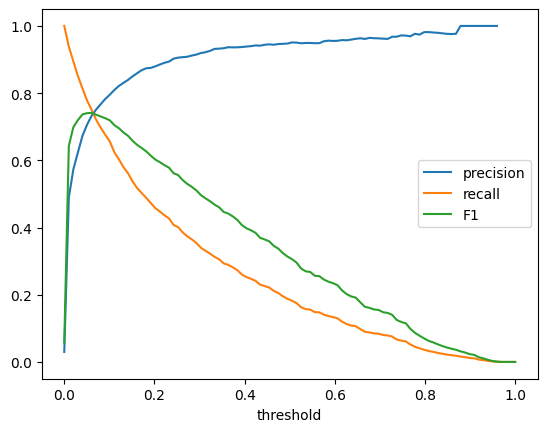

In [66]:
plt.plot(thresholds,precisions)
plt.plot(thresholds,recalls)
plt.plot(thresholds,f1s)
plt.legend(["precision","recall","F1"])
plt.xlabel("threshold")
plt.show()

In [69]:
print("optimal threshold: ")
thresholds[np.argmax(f1s)]

optimal threshold: 


0.06060606060606061

In [112]:
predictedLabels=aux>=0.06

#process labels
processedLabels=labelingProcess(predictedLabels,hyperClose,hyperDuration,samplerate)
""" #get confidence score and filter
predictedAnnotations=labelVectorToAnnotations(predictedLabels,samplerate)
processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
processedAnnotations['confidence']=processedAnnotations.apply(
    lambda row: getConfidence(row,predictedAnnotations)
    ,axis=1)
finalAnnotations=processedAnnotations[processedAnnotations.confidence>0.2].copy().reset_index(drop=True)
finalLabels=excerptAnnotationsToLabels(finalAnnotations,len(testLabels)) """
finalLabels=processedLabels
finalAnnotations=labelVectorToAnnotations(finalLabels,samplerate)

#by event calculations
gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
tp,fp,fn = byEventEvaluation(gtAnnotations,finalAnnotations,thres_IoU=masterIoU)
#consistency check
check=tp*2+fp+fn==len(gtAnnotations)+len(finalAnnotations)

#calculate metrics
vector_F1_raw=F1(testLabels,predictedLabels)
vector_F1=F1(testLabels,finalLabels)
event_F1=2*tp/(2*tp+fp+fn)
event_Precision=tp/(tp+fp)
event_Recall=tp/(tp+fn)
event_TS=tp/(tp+fn+fp)

In [113]:
event_F1

0.7902605724049552

In [114]:
tp

925

In [115]:
fp

372

In [116]:
fn

119

In [124]:
np.min(finalAnnotations.duration)

0.305

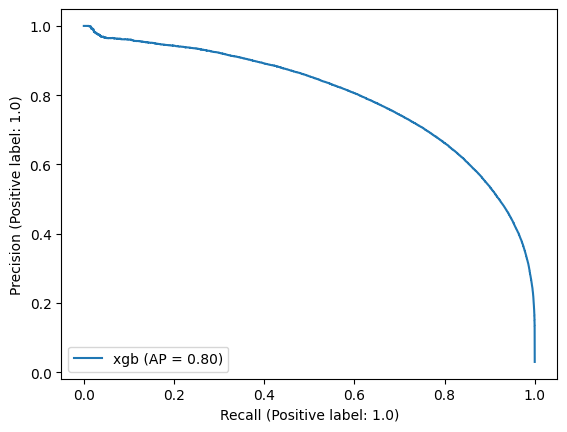

In [120]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

display = PrecisionRecallDisplay.from_estimator(
    model, testFeatures, testLabels, name="xgb"
)


In [121]:
print(average_precision_score(testLabels,aux))


0.795861497186259
